In [127]:
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

f=open(mode='r',file='names.txt')

In [128]:
arr=[]
mapp=defaultdict(int)
for i in f.readlines():
    s=i.strip()
    if mapp[s[0]] > 500:
        continue
    mapp[s[0]]+=1
    s='<s>'+s+'</s>'
    arr.append(s)
f.close()
print(f"Loaded {len(arr)} names",arr[2])

Loaded 11317 names <s>ava</s>


## Building a Trigram Language Model

In [129]:
probabilities=defaultdict(lambda:defaultdict(lambda:defaultdict(int)))

In [130]:
for i in arr:
    for j in range(len(i)-2):
        probabilities[i[j]][i[j+1]][i[j+2]]+=1

In [131]:
for k,v in probabilities.items():
    for k1,v1 in v.items():
        total=sum(v1.values())
        for k2 in v1.keys():
            v1[k2]/=total

In [132]:
chars = sorted(list(set(''.join(arr))))
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}
vocab_size = len(chars)

print(f"Vocabulary size: {vocab_size}")
print(f"Characters: {chars}")

Vocabulary size: 29
Characters: ['/', '<', '>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


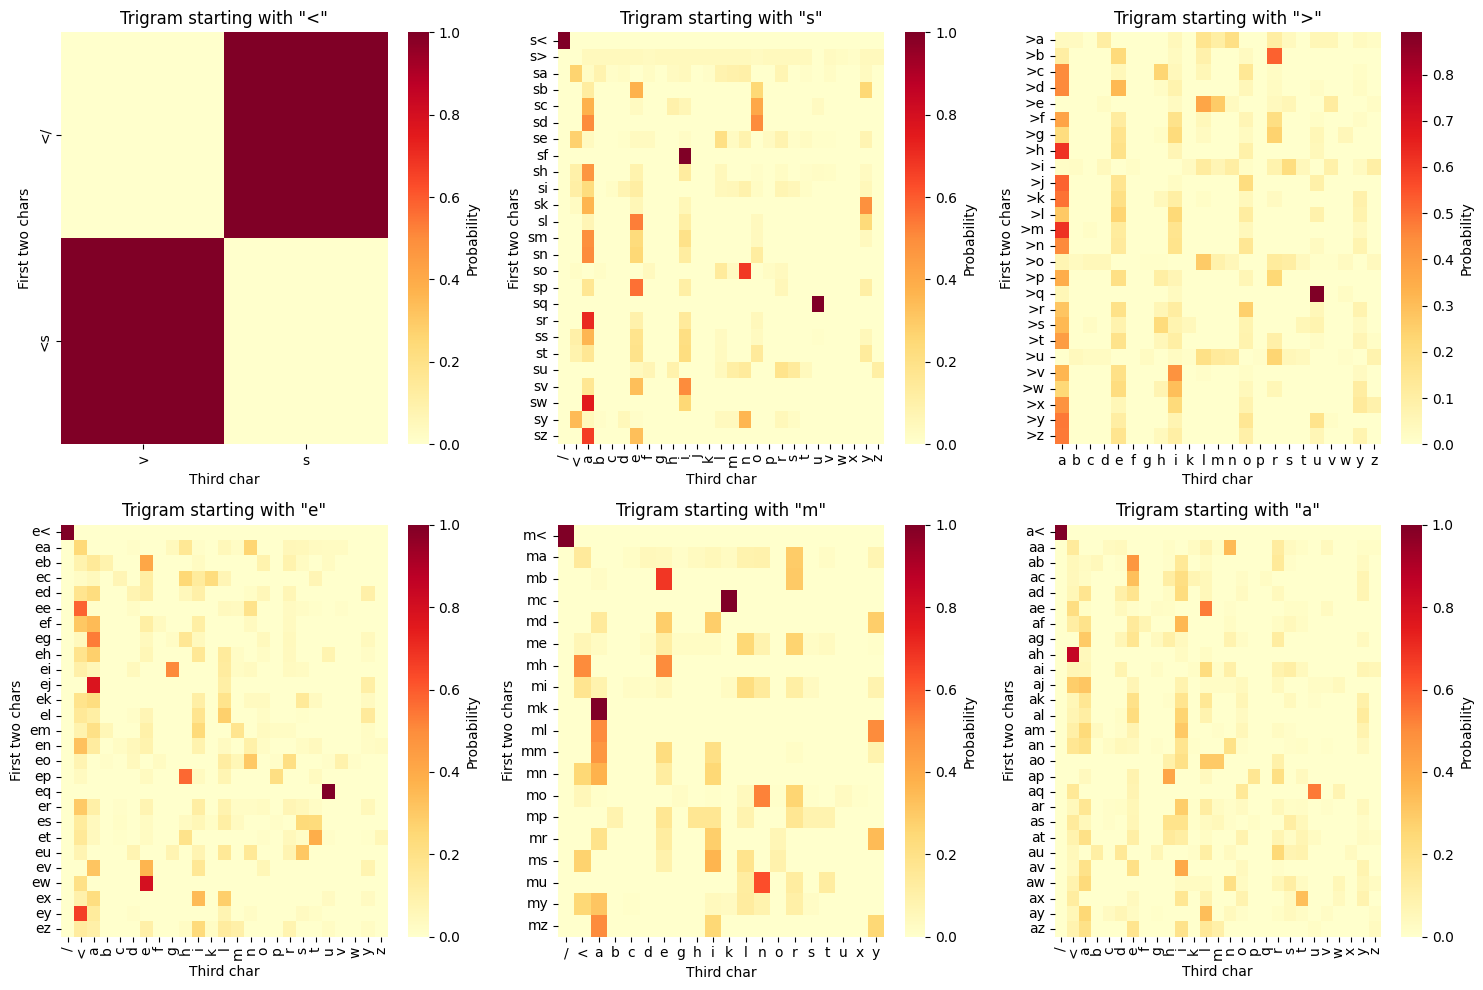

In [133]:
sample_probs = {k: dict(v) for k, v in list(probabilities.items())[:5]}
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (char1, v) in (enumerate
    (list(probabilities.items())[:6])):
    data = []
    labels_x = []
    labels_y = []
    
    for char2, v2 in v.items():
        for char3, prob in v2.items():
            if prob > 0.01:
                labels_y.append(f"{char1}{char2}")
                labels_x.append(char3)
                data.append(prob)
    
    if data:
        matrix = np.zeros((len(set(labels_y)), len(set(labels_x))))
        y_unique = sorted(set(labels_y))
        x_unique = sorted(set(labels_x))
        
        for i, (y, x, val) in enumerate(zip(labels_y, labels_x, data)):
            matrix[y_unique.index(y), x_unique.index(x)] = val
        
        sns.heatmap(matrix, xticklabels=x_unique, yticklabels=y_unique, 
                    cmap='YlOrRd', ax=axes[idx], cbar_kws={'label': 'Probability'})
        axes[idx].set_title(f'Trigram starting with "{char1}"')
        axes[idx].set_xlabel('Third char')
        axes[idx].set_ylabel('First two chars')

plt.tight_layout()
plt.show()

## Building PyTorch Trigram Neural Network

In [134]:
X, Y = [], []
for name in arr:
    for i in range(len(name) - 2):
        ch1, ch2, ch3 = name[i], name[i+1], name[i+2]
        X.append([char_to_idx[ch1], char_to_idx[ch2]])
        Y.append(char_to_idx[ch3])

X = torch.tensor(X)
Y = torch.tensor(Y)
print(f"Training samples: {len(X)}")

Training samples: 125553


In [135]:
class TrigramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=10):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(2 * embedding_dim, 128)
        self.fc2 = nn.Linear(128, vocab_size)
        
    def forward(self, x):
        emb = self.embedding(x).view(x.shape[0], -1)
        h = torch.tanh(self.fc1(emb))
        logits = self.fc2(h)
        return logits

model = TrigramModel(vocab_size)
print(model)

TrigramModel(
  (embedding): Embedding(29, 10)
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=29, bias=True)
)


Epoch 100, Loss: 1.4439
Epoch 200, Loss: 1.3909
Epoch 300, Loss: 1.3719
Epoch 400, Loss: 1.3639
Epoch 500, Loss: 1.3576
Epoch 600, Loss: 1.3541
Epoch 700, Loss: 1.3516
Epoch 800, Loss: 1.3502
Epoch 900, Loss: 1.3492
Epoch 1000, Loss: 1.3473
Epoch 1100, Loss: 1.3464
Epoch 1200, Loss: 1.3457
Epoch 1300, Loss: 1.3450
Epoch 1400, Loss: 1.3444
Epoch 1500, Loss: 1.3443


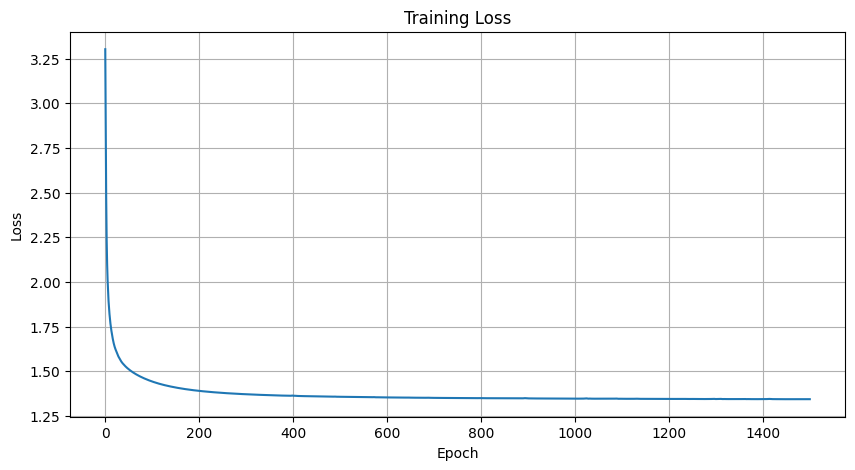

In [136]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
losses = []

for epoch in range(1500):
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

## Inference - Generate Names

In [137]:
def generate_name(model, char_to_idx, idx_to_char, max_length=15):
    model.eval()
    with torch.no_grad():
        name = ''
        ch1, ch2 = '<', 's'
        
        for _ in range(max_length):
            x = torch.tensor([[char_to_idx[ch1], char_to_idx[ch2]]])
            logits = model(x)
            probs = F.softmax(logits, dim=1)
            next_idx = torch.multinomial(probs, num_samples=1).item()
            next_char = idx_to_char[next_idx]
            
            if next_char == '<' and ch2 == '/':
                break
            
            if ch1 == 's' and ch2 == '>':
                name += next_char
            elif ch1 != '<' and ch2 != 's':
                name += next_char
                
            ch1, ch2 = ch2, next_char
                
    return name

In [138]:
max_names = 7

print(f"Generating {max_names} names:\n")
for i in range(max_names):
    name = generate_name(model, char_to_idx, idx_to_char)
    print(f"{i+1}. {name}")

Generating 7 names:

1. maytriyah</k
2. dawa</is/
3. ta</tren</
4. ber</gilauge
5. yukie</jaina
6. carlynnlei</
7. brea</sann<
